# 零基础实战机器学习
第12讲 RNN的优化
作者 黄佳

极客时间专栏链接：https://time.geekbang.org/column/intro/438

问题：根据App的历史激活（即下载后注册用户并使用App）数字，来预测其未来走势

易速鲜花公司拥有过去两年App的日激活数。

通过神经网络中的RNN模型，我们可以对这个时序数据集进行预测。

这里是对RNN模型的一下优化策略。

## 导入数据

In [1]:
import numpy as np #导入NumPy
import pandas as pd #导入Pandas 
df_app = pd.read_csv('../input/flower-app/App.csv', index_col='Date', parse_dates=['Date']) #导入数据
df_app #显示数据

,Activation
Date,
2019-01-01,419
2019-01-02,432
2019-01-03,436
2019-01-04,439
2019-01-05,439
...,...
2021-01-21,916
2021-01-22,925
2021-01-23,926


## 数据可视化


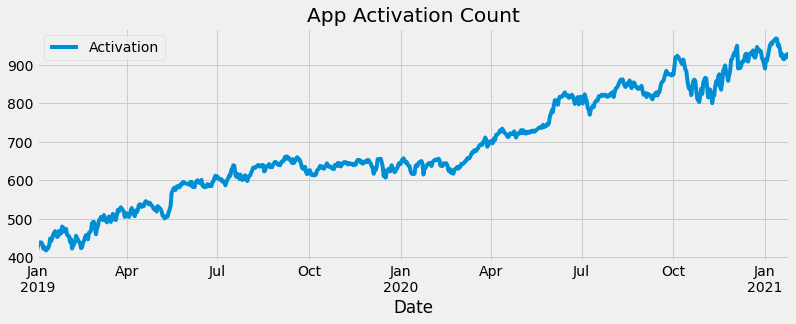

In [2]:
import matplotlib.pyplot as plt #导入matplotlib.pyplot
plt.style.use('fivethirtyeight') #设定绘图风格
df_app["Activation"].plot(figsize=(12,4),legend=True) #绘制激活数
plt.title('App Activation Count') #图题
plt.show() #绘图

## 数据清洗

In [3]:
df_app.isna().sum() #有NaN吗？

Activation    0
dtype: int64

In [4]:
(df_app.Activation < 0).values.any() #有负值吗？

False

## 拆分数据集

In [5]:
# 按照2020年10月1日为界拆分数据集
Train = df_app[:'2020-09-30'].iloc[:,0:1].values #训练集
Test = df_app['2020-10-01':].iloc[:,0:1].values #测试集

In [6]:
#Train #显示训练集对象

In [7]:
print('训练集的形状是：', Train.shape)
print('测试集的形状是：', Test.shape)

训练集的形状是： (639, 1)
测试集的形状是： (117, 1)


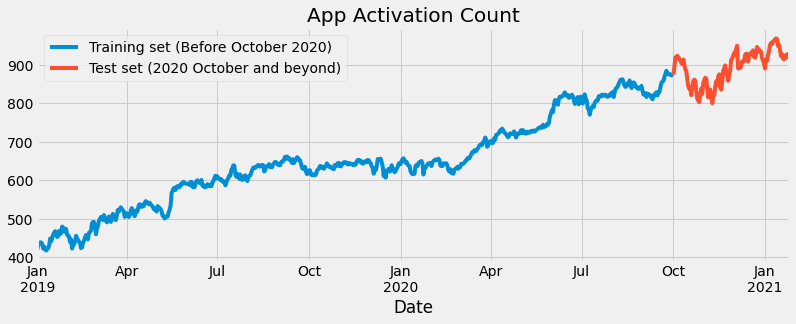

In [8]:
# 以不同颜色为训练集和测试集绘图
df_app["Activation"][:'2020-09-30'].plot(figsize=(12,4),legend=True) #训练集
df_app["Activation"]['2020-10-01':].plot(figsize=(12,4),legend=True) #测试集
plt.legend(['Training set (Before October 2020)','Test set (2020 October and beyond)']) #图例
plt.title('App Activation Count') #图题
plt.show() #绘图

## 特征工程

In [9]:
from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
Scaler = MinMaxScaler(feature_range=(0,1)) #创建缩放器
Train = Scaler.fit_transform(Train) #拟合缩放器并对训练集进行归一化

## 构建特征集和标签集

In [10]:
# 创建具有 60 个时间步长和 1 个输出的数据结构 - 训练集
X_train = [] #初始化
y_train = [] #初始化
for i in range(60,Train.size): 
    X_train.append(Train[i-60:i,0]) #构建特征
    y_train.append(Train[i,0]) #构建标签
X_train, y_train = np.array(X_train), np.array(y_train) #转换为NumPy数组
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1)) #转换成神经网络所需的张量形状

In [11]:
X_train.shape #X_train的形状

(579, 60, 1)

In [12]:
TrainTest = df_app["Activation"][:] #整体数据
inputs = TrainTest[len(TrainTest)-len(Test) - 60:].values #Test加上前60个时间步
inputs = inputs.reshape(-1,1) #转换形状
inputs  = Scaler.transform(inputs) #归一化
# 创建具有 60 个时间步长和 1 个输出的数据结构 - 测试集
X_test = [] #初始化
y_test = [] #初始化
for i in range(60,inputs.size): 
    X_test.append(inputs[i-60:i,0]) #构建特征
    y_test.append(inputs[i,0]) #构建标签
X_test = np.array(X_test) #转换为NumPy数组
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)) #转换成神经网络所需的张量形状

In [13]:
X_test.shape #X_test的形状

(117, 60, 1)

## 选择算法

这里我们采用RNN神经网络算法

In [14]:
from tensorflow.keras.models import Sequential #导入序贯模型
from tensorflow.keras.layers import Dense, LSTM #导入全连接层和LSTM层
# from keras.optimizers import SGD
# LSTM网络架构
RNN_LSTM = Sequential() #序贯模型
RNN_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))) #输入层LSTM,return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间1层LSTM，return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间2层LSTM，return_sequences返回输出序列
RNN_LSTM.add(LSTM(units=50)) #中间3层LSTM
RNN_LSTM.add(Dense(units=1)) #输出层Dense
# 编译网络
RNN_LSTM.compile(optimizer='rmsprop', #优化器
                 loss='mean_squared_error') #损失函数
RNN_LSTM.summary() #输出神经网络结构信息

2021-09-22 14:57:56.066842: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-22 14:57:56.066950: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-22 14:58:00.713044: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-22 14:58:00.715634: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-22 14:58:00.715673: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-22 14:58:00.715699: I tensorflow/stream_executor/cuda/cud

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 训练并保存训练历史信息
history = RNN_LSTM.fit(X_train, y_train, # 指定训练集
                  epochs=30,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便

Epoch 1/30


2021-09-22 14:58:01.866247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-22 14:58:01.877299: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200150000 Hz


8/8 [==============================] - 9s 368ms/step - loss: 0.1033 - val_loss: 0.0722
Epoch 2/30
8/8 [==============================] - 1s 130ms/step - loss: 0.0064 - val_loss: 0.1890
Epoch 3/30
8/8 [==============================] - 1s 150ms/step - loss: 0.0133 - val_loss: 0.0021
Epoch 4/30
8/8 [==============================] - 1s 133ms/step - loss: 0.0112 - val_loss: 0.0227
Epoch 5/30
8/8 [==============================] - 1s 130ms/step - loss: 0.0055 - val_loss: 0.0703
Epoch 6/30
8/8 [==============================] - 1s 129ms/step - loss: 0.0071 - val_loss: 0.0631
Epoch 7/30
8/8 [==============================] - 1s 133ms/step - loss: 0.0107 - val_loss: 0.0371
Epoch 8/30
8/8 [==============================] - 1s 129ms/step - loss: 0.0066 - val_loss: 0.0421
Epoch 9/30
8/8 [==============================] - 1s 129ms/step - loss: 0.0087 - val_loss: 0.0411
Epoch 10/30
8/8 [==============================] - 1s 129ms/step - loss: 0.0065 - val_loss: 0.0090
Epoch 11/30
8/8 [=============

In [16]:
def show_history(history): # 显示训练过程中的学习曲线
    loss = history.history['loss'] #训练损失
    val_loss = history.history['val_loss'] #验证损失
    epochs = range(1, len(loss) + 1) #训练轮次
    plt.figure(figsize=(12,4)) # 图片大小
    plt.subplot(1, 2, 1) #子图1
    plt.plot(epochs, loss, 'bo', label='Training loss') #训练损失
    plt.plot(epochs, val_loss, 'b', label='Validation loss') #验证损失
    plt.title('Training and validation loss') #图题
    plt.xlabel('Epochs') #X轴文字
    plt.ylabel('Loss') #Y轴文字
    plt.legend() #图例
    plt.show() #绘图

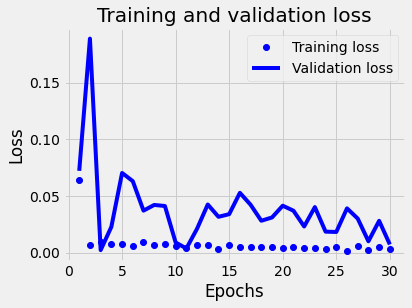

In [17]:
show_history(history) # 调用绘图函数

In [18]:
# 定义绘图函数
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Count') #真值
    plt.plot(predicted, color='blue',label='Predicted Count') #预测值
    plt.title('Flower App Activation Prediction') #图题
    plt.xlabel('Time') #X轴时间
    plt.ylabel('Flower App Activation Count') #Y轴激活数
    plt.legend() #图例
    plt.show() #绘图

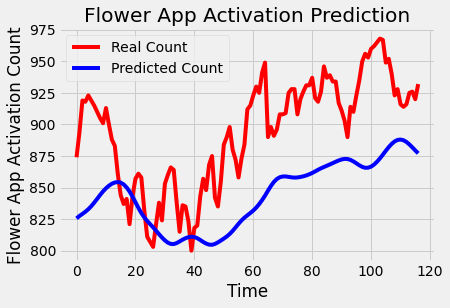

In [19]:
y_pred = RNN_LSTM.predict(X_test) #预测
Pred = Scaler.inverse_transform(y_pred) #反归一化
plot_predictions(Test,Pred) #绘图

In [20]:
import math #导入数学函数
from sklearn.metrics import mean_squared_error
def return_rmse(test,predicted): #定义均方损失函数
    rmse = math.sqrt(mean_squared_error(test, predicted)) #均方损失
    print("MSE损失值 {}.".format(rmse))

In [21]:
return_rmse(y_test,y_pred) #计算均方损失

MSE损失值 0.12440364639761588.


## 第一个调优

In [22]:
from tensorflow.keras.models import Sequential #导入序贯模型
from tensorflow.keras.layers import Dense, LSTM, Dropout #导入全连接层,LSTM层和Dropout层
# from keras.optimizers import SGD
# LSTM网络架构
RNN_LSTM = Sequential() #序贯模型
RNN_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))) #输入层LSTM,return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间1层LSTM，return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间2层LSTM，return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(LSTM(units=50)) #中间3层LSTM
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(Dense(units=1)) #输出层Dense
# 编译网络
RNN_LSTM.compile(optimizer='rmsprop', #优化器
                 loss='mean_squared_error') #损失函数
RNN_LSTM.summary() #输出神经网络结构信息

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

Epoch 1/30
8/8 [==============================] - 9s 326ms/step - loss: 0.1116 - val_loss: 0.0181
Epoch 2/30
8/8 [==============================] - 1s 133ms/step - loss: 0.0073 - val_loss: 0.0164
Epoch 3/30
8/8 [==============================] - 1s 136ms/step - loss: 0.0096 - val_loss: 0.0044
Epoch 4/30
8/8 [==============================] - 1s 136ms/step - loss: 0.0141 - val_loss: 0.0119
Epoch 5/30
8/8 [==============================] - 1s 137ms/step - loss: 0.0094 - val_loss: 0.0301
Epoch 6/30
8/8 [==============================] - 1s 137ms/step - loss: 0.0054 - val_loss: 0.0218
Epoch 7/30
8/8 [==============================] - 1s 144ms/step - loss: 0.0119 - val_loss: 0.0155
Epoch 8/30
8/8 [==============================] - 1s 137ms/step - loss: 0.0050 - val_loss: 0.0802
Epoch 9/30
8/8 [==============================] - 1s 139ms/step - loss: 0.0121 - val_loss: 0.0667
Epoch 10/30
8/8 [==============================] - 1s 136ms/step - loss: 0.0101 - val_loss: 0.0368
Epoch 11/30
8/8 [==

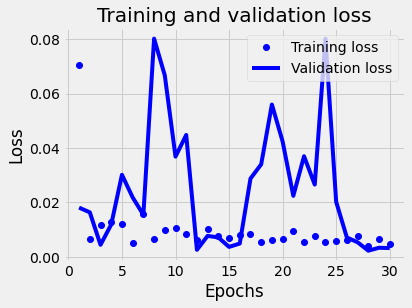

In [23]:
# 训练并保存训练历史信息
history = RNN_LSTM.fit(X_train, y_train, # 指定训练集
                  epochs=30,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便
show_history(history) # 调用绘图函数

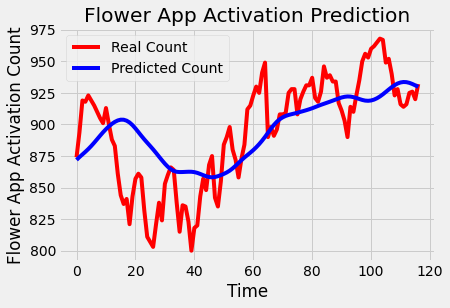

In [24]:
y_pred = RNN_LSTM.predict(X_test) #预测
Pred = Scaler.inverse_transform(y_pred) #反归一化
plot_predictions(Test,Pred) #绘图

In [25]:
return_rmse(y_test,y_pred) #计算均方损失

MSE损失值 0.06858456451467569.


## 第二个调优

In [26]:
from tensorflow.keras.models import Sequential #导入序贯模型
from tensorflow.keras.layers import Dense, LSTM, Dropout #导入全连接层,LSTM层和Dropout层
from tensorflow.keras.optimizers import Adam
# LSTM网络架构
RNN_LSTM = Sequential() #序贯模型
RNN_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))) #输入层LSTM,return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间1层LSTM，return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(LSTM(units=50, return_sequences=True)) #中间2层LSTM，return_sequences返回输出序列
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(LSTM(units=50)) #中间3层LSTM
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(Dense(units=1)) #输出层Dense
# 编译网络
RNN_LSTM.compile(optimizer=Adam(lr=1e-4), #更新优化器并设定学习速率
                 loss='mean_squared_error') #损失函数
RNN_LSTM.summary() #输出神经网络结构信息

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)               

Epoch 1/30
8/8 [==============================] - 9s 328ms/step - loss: 0.1761 - val_loss: 0.5061
Epoch 2/30
8/8 [==============================] - 1s 134ms/step - loss: 0.1241 - val_loss: 0.3472
Epoch 3/30
8/8 [==============================] - 1s 136ms/step - loss: 0.0758 - val_loss: 0.1856
Epoch 4/30
8/8 [==============================] - 1s 136ms/step - loss: 0.0323 - val_loss: 0.0504
Epoch 5/30
8/8 [==============================] - 1s 139ms/step - loss: 0.0084 - val_loss: 0.0032
Epoch 6/30
8/8 [==============================] - 1s 145ms/step - loss: 0.0105 - val_loss: 0.0040
Epoch 7/30
8/8 [==============================] - 1s 135ms/step - loss: 0.0081 - val_loss: 0.0214
Epoch 8/30
8/8 [==============================] - 1s 136ms/step - loss: 0.0064 - val_loss: 0.0330
Epoch 9/30
8/8 [==============================] - 1s 139ms/step - loss: 0.0063 - val_loss: 0.0238
Epoch 10/30
8/8 [==============================] - 1s 155ms/step - loss: 0.0051 - val_loss: 0.0144
Epoch 11/30
8/8 [==

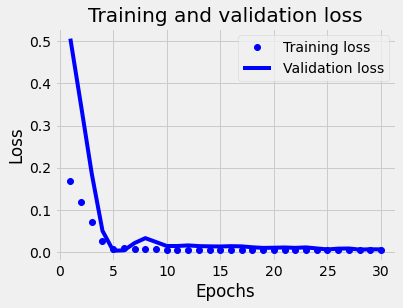

In [27]:
# 训练并保存训练历史信息
history = RNN_LSTM.fit(X_train, y_train, # 指定训练集
                  epochs=30,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便
show_history(history) # 调用绘图函数

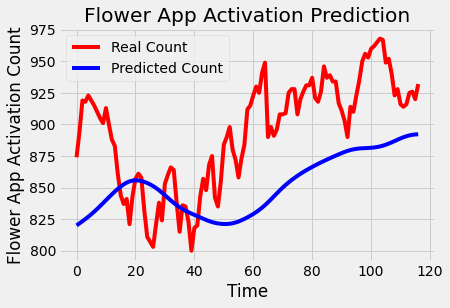

In [28]:
y_pred = RNN_LSTM.predict(X_test) #预测
Pred = Scaler.inverse_transform(y_pred) #反归一化
plot_predictions(Test,Pred) #绘图

In [29]:
return_rmse(y_test,y_pred) #计算均方损失

MSE损失值 0.11949613622031498.
